# Bayesian Linear Regression

For a bayesian linear regression, as oridinary least squares regression, we first assume that our target variable, $t$ is given by a deterministic function:

$$
y(\textbf{x}, \textbf{w}) + \epsilon
$$

Where $\epsilon$ is a zero mean Gaussian variable with inverse variance $\beta$. Thus we can write:

$$p(t\vert \textbf{x}, \textbf{w}, \beta) = \mathcal{N}(t \vert y(\textbf{x}, \textbf{w}), \beta^{-1})$$

which is a conditional Gaussian distribution with mean $y(\textbf{x}, \textbf{w})$ and inverse variance $\beta$.

For our prior, if we use a zero-mean isotropic Gaussian governed by a single precision parameter $\alpha$ so that: 

$$p(\textbf{w}\vert\alpha) = \mathcal{N}({\textbf{w}\vert \textbf{0}}, \alpha^{-1}\textbf{I})$$

then, the corresponding posterior has a closed form solution given by:

$$p(\textbf{w}\vert\textbf{t}) = \mathcal{N}(\textbf{w}\vert\textbf{m}_{N}, \textbf{S}_{N})$$

where:

$$
\begin{align}
\textbf{m}_{N} &= \beta \textbf{S}_{N} \Phi^{T}\textbf{t}\\
\textbf{S}_N^{-1} &= \alpha \textbf{I} + \beta \Phi^{T}\Phi
\end{align}
$$

In practice, we are not usaully interested in the single values of $w$ but rather in making predictions of $t$ for new values of $\textbf{x}$. This is done by using the predictive distribution, defined as follows: 

$$p(t\vert\textbf{t},\alpha,\beta) = \int p(t\vert\textbf{w},\beta)p(\textbf{w}\vert\textbf{t},\alpha,\beta)$$

The conditional distribution $p(t\vert\textbf{w}\beta)$ is defined in the model above. $p(\textbf{w}\vert\textbf{t},\alpha,\beta)$ represents our posterior distribution which is given by the closed form solution above. The predictive distribution is the convolution of two Gaussian distributions meaning that the predictive distribution is also Gaussian and is defined as follows: 

$$p(t\vert\textbf{x},\textbf{t},\alpha,\beta) = \mathcal{N}(t\vert\textbf{m}_{N}^{T}\phi(\textbf{x}), \sigma_{N}^{2}(\textbf{x}))$$

where the variance $\sigma_{N}^{2}$ is given by:

$$\sigma_{N}^{2} = \dfrac{1}{\beta} + \phi(\textbf{x})^{T}\textbf{S}_{N}\phi{\textbf{(x)}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from basis_expansion_utils import *
import scipy as sp
from functools import partial
from scipy import stats

In [2]:
a0 = -0.3
a1 = 0.5

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

def f(X, noise_variance):
    return a0 + a1 * X + noise(X.shape, noise_variance)

def sinusoidal(X, noise_variance):
    return np.sin(2 * np.pi * X) + noise(X.shape, noise_variance) 

In [3]:
def posterior(alpha, beta, phi, t):
    '''mean and covariance matrix of the posterior'''
    S_N_inv = alpha * np.eye(phi.shape[1]) + beta * np.dot(phi.T,phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(phi.T).dot(t)
    return m_N, S_N

def predictive(phi, m_n, S_n, beta):
    mean = m_N.T.dot(phi.T).reshape(-1,1)
    # TODO: why doesn't below work!!
    #variance = 1/beta + np.sum(phi.dot(S_N).dot(phi.T), axis=1).reshape(-1,1)
    var = 1 / beta + np.sum(phi.dot(S_N) * phi, axis=1)
    return mean, var

def plot_truth(X,y):
    plt.plot(X,y,"--", c="black", label="truth")

def plot_observed(X,y):
    plt.scatter(X[:,0:],t, c="black", label="observed")
    
def plot_posterior_samples(X, y_sample):
    for c in range(y_sample.shape[1]):
        plt.plot(X.ravel(), y_sample[:,c], c="red")
        
def plot_predictive(X,y,std):
    X = X.ravel()
    y = y.ravel()
    std = std.ravel()
    plt.plot(X,y)
    plt.fill_between(X, y + std, y - std, alpha = 0.5)
    
def plot_posterior(m_N, S_N):
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("$w_{0}$")
    plt.ylabel("$w_{1}$")
    w0_vals = np.linspace(-1,1,100)
    w1_vals = np.linspace(-1,1,100)
    stacked = np.dstack(np.meshgrid(w0_vals, w1_vals))
    Z = stats.multivariate_normal.pdf(stacked, mean=m_N.ravel(), cov=S_N)
    plt.contour(w0_vals, w1_vals, Z)

In [4]:
# create synthetic data
beta = 25
alpha = 2
variance = 1/beta

X = (np.random.rand(6,1) * 2 - 1)
t = f(X, noise_variance=variance)

In [5]:
phi = basis_expansion(X)
post_mean, post_var = posterior(alpha, beta, phi, t)

Create truth data

In [6]:
X_test = np.linspace(-1,1,100).reshape(-1, 1)
phi_test = basis_expansion(X_test)
y_true = f(X_test, noise_variance=0)

Becasue the posterior is gaussian, the mode coincides with the mean. Therefore, the maximum posterior weight vector is given by $\textbf{w}_{\text{MAP}} = \textbf{m}_{N}$

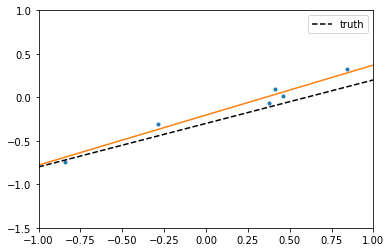

In [7]:
plt.plot(X,t, ".")
plt.xlim(-1, 1)
plt.ylim(-1.5, 1)
plt.plot(X_test, phi_test.dot(post_mean))
plt.plot(X_test, y_true, '--', c="black", label="truth")
plt.legend()

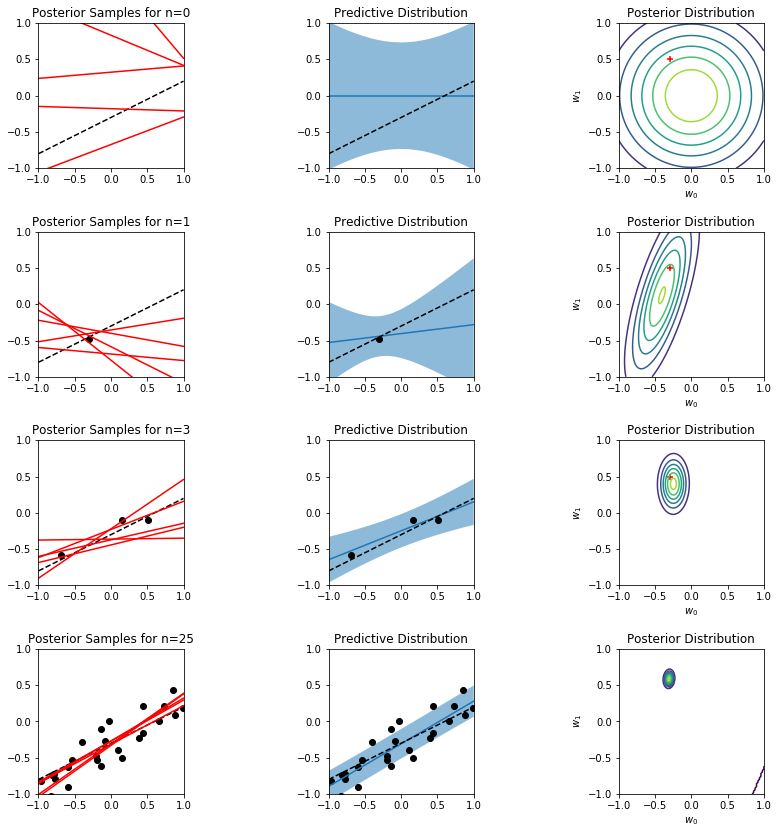

In [8]:
plt.figure(figsize=(13, 15))
plt.subplots_adjust(hspace=0.1, wspace=1)

N = [0, 1, 3, 25]
for i, n in enumerate(N): 
    X = (np.random.rand(n,1) * 2 - 1)
    t = f(X, noise_variance=variance)
    phi = basis_expansion(X, identity_basis)
    m_N, S_N = posterior(alpha, beta, phi, t)
      
    post_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5)
    y, y_var = predictive(phi_test, m_N, S_N, beta)
    
    plt.subplot(len(N), 3, i * 3 + 1)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"Posterior Samples for n={n}")

    plot_truth(X_test,y_true)
    plot_observed(X,t)
    y_sample = post_samples.dot(phi_test.T).T
    plot_posterior_samples(X_test, y_sample)
    
    plt.subplot(len(N), 3, i * 3 + 2)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Predictive Distribution")
    plot_predictive(X_test, y, np.sqrt(y_var))
    plot_observed(X,t)
    plot_truth(X_test,y_true)
    
    # plt posterior
    plt.subplot(len(N), 3, i * 3 + 3)
    plt.scatter(a0, a1, marker="+", c="red")
    plot_posterior(m_N, S_N)
    plt.title("Posterior Distribution")

plt.draw()

Now, let's generate some non-linear data

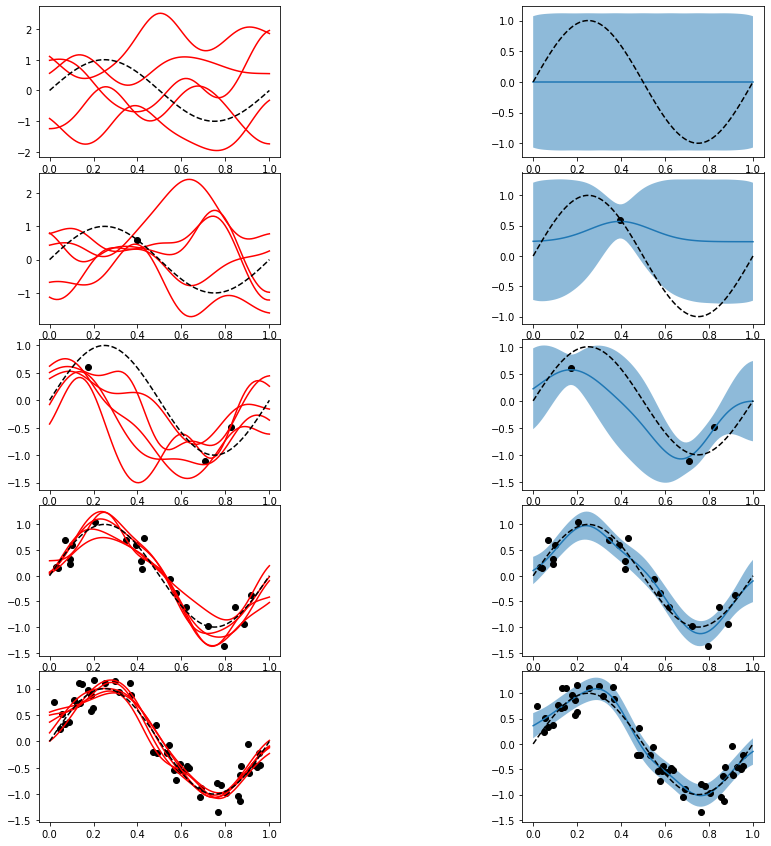

In [61]:
# plot params
plt.figure(figsize=(13, 15))
plt.subplots_adjust(hspace=0.1, wspace=1)


# truth data
x_test = np.linspace(0,1,100).reshape(-1, 1)
mus = np.linspace(0, 1, 9)
phi_test = basis_expansion(x_test, gaussian_radial_basis, mus=mus)
t_true = sinusoidal(x_test, noise_variance=0)
alpha = 2
beta = 25

N_sizes = [0,1,3,20,50]

for i, n in enumerate(N_sizes):

    X = np.random.rand(n, 1)
    phi = basis_expansion(X, gaussian_radial_basis, mus=mus)
    t = sinusoidal(X, noise_variance=1/beta)

    m_N, S_N = posterior(alpha, beta, phi, t)
    post_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = phi_test.dot(post_samples)
    
    plt.subplot(len(N_sizes),2,2*i+1)
    plot_posterior_samples(x_test, y_samples)
    plot_truth(x_test, t_true)
    plot_observed(X, t)
    y, y_var = predictive(phi_test, m_N, S_N, beta)
    
    plt.subplot(len(N_sizes),2, 2*i+2)
    plot_predictive(x_test, y, np.sqrt(y_var))
    plot_observed(X, t)
    plot_truth(x_test, t_true)